In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from cvxopt import matrix, solvers
c = matrix([-4., -5.])
G = matrix([[2., 1., -1., 0.], [1., 2., 0., -1.]])
h = matrix([3., 3., 0., 0.])
A = matrix([[1., 0.], [0., 1]])
b = matrix([0., 0.])
sol = solvers.lp(c, G, h, A=A, b=b)
print(sol['x'])

     pcost       dcost       gap    pres   dres   k/t
 0: -1.4504e-15 -6.0000e+00  1e+01  5e-01  4e-01  1e+00
 1:  5.6511e-16 -4.6892e-02  7e-02  8e-03  8e-03  8e-02
 2:  5.9089e-18 -4.6827e-04  7e-04  8e-05  8e-05  8e-04
 3:  5.9105e-20 -4.6825e-06  7e-06  8e-07  8e-07  8e-06
 4:  5.9105e-22 -4.6825e-08  7e-08  8e-09  8e-09  8e-08
Optimal solution found.
[ 1.18e-22]
[-2.12e-22]



In [3]:
%%HTML
<style type="text/css">
table, td{
    border-style: solid;
}
th {
  background-color: #4CAF50;
  color: white;
}
tr:nth-child(even) {background-color: #f0f0f0;}
tr:hover {background-color: #4CAF50;}

In [4]:
from pypower.api import case30pwl, case30Q 
from pypower.api import case30, ppoption, runpf, printpf, runopf
from pypower.loadcase import loadcase

import utils
from utils import get_cols, LAM_P, MU_PMAX, PF
from pypower.api import opf_consfcn, opf_costfcn
from pypower.idx_bus import BUS_TYPE, REF, VM, VA, MU_VMAX, MU_VMIN, LAM_P, LAM_Q
from scipy.optimize import minimize, nnls, linprog

In [5]:
bus_cols, gen_cols, brch_cols, cost_cols = get_cols()

In [6]:
ppc = case30()

ppopt = ppoption(PF_ALG=1, RETURN_RAW_DER=True, OPF_FLOW_LIM=1)
#ppopt

In [7]:
gens = ppc['gen'][:, 0]

load_list = []
bids = [6, 7, 15, 19, 29]
for bus_str in ppc['bus']:
    tmp = np.zeros(21)
    if bus_str[0] not in gens:
        if bus_str[0] not in gens and (bus_str[0] in bids):
            #print('load #%d' % bus_str[0])
            tmp[0] = bus_str[0]

            tmp[1] = -30.#bus_str[2]
            tmp[2] = -15.#bus_str[3]

            tmp[3] = -0.0001
            tmp[4] = -15.

            tmp[5] = bus_str[7]
            tmp[6] = 100.

            tmp[7] = 1.

            #fixed here
            tmp[8] = -0.0001
            tmp[9] = -30.

            bus_str[2], bus_str[3] = 0., 0.
            load_list.append(tmp)
ppc['gen'] = np.concatenate((ppc['gen'], np.array(load_list)))

In [8]:
alpha = 1.01
#bound max flow 3 + 1 <-> 11 + 1
ppc['branch'][14][5] *= alpha
#bound max flow 9 + 1 <-> 16 + 1
ppc['branch'][25][5] *= alpha
#bound max flow 27 <-> 26
#ppc['branch'][35][5] *= alpha
#bound max flow 18 <-> 19
ppc['branch'][23][5] *= alpha
#bound max flow 22 <-> 23
ppc['branch'][31][5] *= alpha

## Data preparation to fulfil the task

Bus data:

<table>
    <tr>
            <td> $bus_i$ </td>
            <td> type </td>
            <td> $P_d$ </td>
            <td> $Q_d$ </td>
            <td> $G_s$ </td>
            <td> $B_s$ </td>
            <td> area </td>
            <td> $V_m$ </td>
            <td> $V_a$ </td>
            <td> base~KV </td>
            <td> zone </td>
            <td> $V_{max}$ </td>
            <td> $V_{min}$ </td>
    </tr>
</table>

Generator data:

<table>
    <tr>
            <td> $bus$ </td>
            <td> $P_g$ </td>
            <td> $Q_g$ </td>
            <td> $Q_{max}$ </td>
            <td> $Q_{min}$ </td>
            <td> mBase </td>
            <td> status </td>
            <td> $P_{max}$ </td>
            <td> $P_{min}$ </td>
            <td> $\ldots$ </td>
    </tr>
</table>

Generator cost data has the following structure:

<table>
    <tr>
            <td> 1 </td>
            <td> startup </td>
            <td> shutdown </td>
            <td> n </td>
            <td> $x_1$ </td>
            <td> $y_1$ </td>
            <td> $\ldots$ </td>
            <td> $x_n$ </td>
            <td> $y_n$ </td>
    </tr>
    <tr>
            <td> 2 </td>
            <td> startup </td>
            <td> shutdown </td>
            <td> n </td>
            <td> $c_{n - 1}$ </td>
            <td> $\ldots$ </td>
            <td> $\ldots$ </td>
            <td> $\ldots$ </td>
            <td> $c_0$ </td>
    </tr>
</table>

Convert cost function to linear changing the order of polynom to 1

In [9]:
ppc['gencost'][:,3] = np.ones(ppc['gencost'].shape[0]) * 2
ppc['gencost'] = ppc['gencost'][:,[0,1,2,3,5,6]]
pd.DataFrame(ppc['gencost'])

,0,1,2,3,4,5
0,2.0,0.0,0.0,2.0,2.00,0.0
1,2.0,0.0,0.0,2.0,1.75,0.0
2,2.0,0.0,0.0,2.0,1.00,0.0
3,2.0,0.0,0.0,2.0,3.25,0.0
4,2.0,0.0,0.0,2.0,3.00,0.0
5,2.0,0.0,0.0,2.0,3.00,0.0


In [10]:
cost_list = []

for load in load_list:
    cost_list.append(np.array([2., 0., 0., 2., -10., 0]))
    
ppc['gencost'] = np.concatenate((ppc['gencost'], np.array(cost_list)))

In [11]:
#ppc['gencost'][:, 4] = np.zeros(ppc['gencost'].shape[0])

ppc['gencost'][-6: , 4] = 0.
pd.DataFrame(ppc['gencost'])

,0,1,2,3,4,5
0,2.0,0.0,0.0,2.0,2.00,0.0
1,2.0,0.0,0.0,2.0,1.75,0.0
2,2.0,0.0,0.0,2.0,1.00,0.0
3,2.0,0.0,0.0,2.0,3.25,0.0
4,2.0,0.0,0.0,2.0,3.00,0.0
5,2.0,0.0,0.0,2.0,0.00,0.0
6,2.0,0.0,0.0,2.0,0.00,0.0
7,2.0,0.0,0.0,2.0,0.00,0.0
8,2.0,0.0,0.0,2.0,0.00,0.0
9,2.0,0.0,0.0,2.0,0.00,0.0


Also it contains only generation costs, to satisfy welfare cost function:

\begin{equation}
f = \sum\limits_{d \in {\cal D}} C_dP_d - \sum\limits_{g \in {\cal G}} C_gP_g = {\bf C}_d^{\top}{\bf P}_d - {\bf C}_g^{\top}{\bf P}_g\to \max
\end{equation}

From `MATPOWER` documentation the standard OPF problem takes the following form:

\begin{align}
\min_x~& f(x)\\
s.t.~&g(x) = 0\\
&h(x) \leq 0\\
x_{{\rm min}} &\leq x \leq x_{{\rm max}}
\end{align}

Then

\begin{equation}
f = {\bf C}_g^{\top}{\bf P}_g - {\bf C}_d^{\top}{\bf P}_d \to \min
\end{equation}


In [12]:
ppopt = ppoption(VERBOSE=0)
results = runopf(ppc, ppopt)


Converged in 0.96 seconds
Objective Function Value = 201.54 $/hr
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses             30     Total Gen Capacity     335.0        -170.0 to 405.9
Generators        11     On-line Capacity       335.0        -170.0 to 405.9
Committed Gens    11     Generation (actual)    148.8              89.0
Loads             16     Load                   146.3              89.5
  Fixed           16       Fixed                146.3              89.5
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts             2     Shunt (inj)             -0.0               0.2
Branches          41     Losses (I^2 * Z)         2.53             14.53
Transformers       0     Branch Charging (inj)     -               14.9
Inter-ties         7     Total Inter-ti

In [13]:
pd.DataFrame(results['bus'], columns=bus_cols)

,BUS_I,BUS_TYPE,PD,QD,GS,BS,BUS_AREA,VM,VA,BASE_KV,ZONE,VMAX,VMIN,LAM_P,LAM_Q,MU_VMAX,MU_VMIN
0,1.0,3.0,0.0,0.0,0.0,0.00,1.0,0.964263,0.000000,135.0,1.0,1.05,0.95,1.754031,-1.231225e-06,0.000000,0.000000
1,2.0,2.0,21.7,12.7,0.0,0.00,1.0,0.964229,0.116097,135.0,1.0,1.10,0.95,1.750000,-4.778816e-07,0.000000,0.000000
2,3.0,1.0,2.4,1.2,0.0,0.00,1.0,0.966775,-0.389519,135.0,1.0,1.05,0.95,1.765072,-1.172930e-03,0.000000,0.000000
3,4.0,1.0,7.6,1.6,0.0,0.00,1.0,0.967682,-0.413409,135.0,1.0,1.05,0.95,1.766416,-1.481091e-03,0.000000,0.000000
4,5.0,1.0,0.0,0.0,0.0,0.19,1.0,0.961953,-0.144883,135.0,1.0,1.05,0.95,1.749907,-2.304732e-03,0.000000,0.000000
5,6.0,1.0,0.0,0.0,0.0,0.00,1.0,0.961055,-0.438640,135.0,1.0,1.05,0.95,1.751732,-6.041650e-03,0.000000,0.000000
6,7.0,1.0,0.0,0.0,0.0,0.00,1.0,0.958177,-0.247280,135.0,1.0,1.05,0.95,1.751142,1.289802e-06,0.000000,0.000000
7,8.0,1.0,30.0,30.0,0.0,0.00,1.0,0.950000,-0.926795,135.0,1.0,1.05,0.95,12.632364,9.002930e+00,0.000000,70.652036
8,9.0,1.0,0.0,0.0,0.0,0.00,1.0,0.968805,0.423623,135.0,1.0,1.05,0.95,2.000233,2.064962e-01,0.000000,0.000000
9,10.0,1.0,5.8,2.0,0.0,0.00,3.0,0.972952,0.869749,135.0,1.0,1.05,0.95,2.126264,3.193693e-01,0.000000,0.000000


In [14]:
pd.DataFrame(ppc['gen'], columns=gen_cols)

,GEN_BUS,PG,QG,QMAX,QMIN,VG,MBASE,GEN_STATUS,PMAX,PMIN,...,QC2MAX,RAMP_AGC,RAMP_10,RAMP_30,RAMP_Q,APF,MU_PMAX,MU_PMIN,MU_QMAX,MU_QMIN
0,1.0,23.54,0.0,150.0000,-20.0,1.0,100.0,1.0,80.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,60.97,0.0,60.0000,-20.0,1.0,100.0,1.0,80.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,22.0,21.59,0.0,62.5000,-15.0,1.0,100.0,1.0,50.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,27.0,26.91,0.0,48.7000,-15.0,1.0,100.0,1.0,55.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,23.0,19.20,0.0,40.0000,-10.0,1.0,100.0,1.0,30.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,13.0,37.00,0.0,44.7000,-15.0,1.0,100.0,1.0,40.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,6.0,-30.00,-15.0,-0.0001,-15.0,1.0,100.0,1.0,-0.0001,-30.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,7.0,-30.00,-15.0,-0.0001,-15.0,1.0,100.0,1.0,-0.0001,-30.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,15.0,-30.00,-15.0,-0.0001,-15.0,1.0,100.0,1.0,-0.0001,-30.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,19.0,-30.00,-15.0,-0.0001,-15.0,1.0,100.0,1.0,-0.0001,-30.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
pd.DataFrame(results['gen'], columns=gen_cols)

,GEN_BUS,PG,QG,QMAX,QMIN,VG,MBASE,GEN_STATUS,PMAX,PMIN,...,QC2MAX,RAMP_AGC,RAMP_10,RAMP_30,RAMP_Q,APF,MU_PMAX,MU_PMIN,MU_QMAX,MU_QMIN
0,1.0,0.000095,-3.332733,150.0000,-20.0,0.964263,100.0,1.0,80.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.245969,0.000000,0.000000
1,2.0,35.664197,4.811413,60.0000,-20.0,0.964229,100.0,1.0,80.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2,22.0,43.850897,-5.358493,62.5000,-15.0,0.980580,100.0,1.0,50.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
3,27.0,29.316611,48.699928,48.7000,-15.0,1.079016,100.0,1.0,55.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.324212,0.000000
4,23.0,0.000020,27.443746,40.0000,-10.0,1.041248,100.0,1.0,30.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.175744,0.000000,0.000000
5,13.0,39.999987,44.699740,44.7000,-15.0,1.081348,100.0,1.0,40.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.847887,0.000000,0.089125,0.000000
6,6.0,-0.000113,-14.985977,-0.0001,-15.0,0.961055,100.0,1.0,-0.0001,-30.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.751733,0.000000,0.000000,0.006043
7,7.0,-0.000113,-7.278499,-0.0001,-15.0,0.958177,100.0,1.0,-0.0001,-30.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.751142,0.000000,0.000000,0.000000
8,15.0,-0.000112,-0.000362,-0.0001,-15.0,1.021830,100.0,1.0,-0.0001,-30.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.880939,0.000000,0.089365,0.000000
9,19.0,-0.000112,-0.000207,-0.0001,-15.0,0.990169,100.0,1.0,-0.0001,-30.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.031348,0.000000,0.218162,0.000000


In [16]:
ppc['gencost'][:,4][: 6] = 400
ppc['gencost'][:,4][6: ] = -10
ppc['gencost'][:,4][-6: ] = -10

In [33]:
#ppc['gencost'][0, 5] = 500.
#ppc['gencost'][1, 5] = 500.
#ppc['gencost'][3, 5] = 300.
#ppc['gencost'][2, 5] = 100.
#ppc['gencost'][4, 5] = 5.
#ppc['gencost'][5, 5] = 5.
ppc['gencost'][0, 4] = 15.
ppc['gencost'][1, 4] = 10.
ppc['gencost'][3, 4] = 15.
ppc['gencost'][2, 4] = 10.
ppc['gencost'][4, 4] = 50.
ppc['gencost'][5, 4] = 30.
ppc['gencost'][:,4:] *= 100.
#pd.DataFrame(ppc['gencost'])
ppc['gencost'][:,4] /= 2.5
ppc['gencost'][4,4] = 10000.

In [34]:
results = runopf(ppc, ppopt)


Converged in 1.21 seconds
Objective Function Value = 66429.56 $/hr
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses             30     Total Gen Capacity     335.0        -170.0 to 405.9
Generators        11     On-line Capacity       335.0        -170.0 to 405.9
Committed Gens    11     Generation (actual)    149.1              89.1
Loads             16     Load                   146.3              89.5
  Fixed           16       Fixed                146.3              89.5
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts             2     Shunt (inj)             -0.0               0.2
Branches          41     Losses (I^2 * Z)         2.82             14.74
Transformers       0     Branch Charging (inj)     -               14.9
Inter-ties         7     Total Inter-

In [35]:
pd.DataFrame(results['bus'], columns=bus_cols)
#pd.DataFrame(results['gen'], columns=gen_cols)

,BUS_I,BUS_TYPE,PD,QD,GS,BS,BUS_AREA,VM,VA,BASE_KV,ZONE,VMAX,VMIN,LAM_P,LAM_Q,MU_VMAX,MU_VMIN
0,1.0,3.0,0.0,0.0,0.0,0.00,1.0,0.965541,0.000000,135.0,1.0,1.05,0.95,402.865189,-1.570218e-06,0.000000,0.000000
1,2.0,2.0,21.7,12.7,0.0,0.00,1.0,0.967706,0.411387,135.0,1.0,1.10,0.95,400.000006,-7.516830e-07,0.000000,0.000000
2,3.0,1.0,2.4,1.2,0.0,0.00,1.0,0.965915,-1.386453,135.0,1.0,1.05,0.95,410.581540,-1.204969e+00,0.000000,0.000000
3,4.0,1.0,7.6,1.6,0.0,0.00,1.0,0.966481,-1.619699,135.0,1.0,1.05,0.95,411.935203,-1.502920e+00,0.000000,0.000000
4,5.0,1.0,0.0,0.0,0.0,0.19,1.0,0.962719,-0.531166,135.0,1.0,1.05,0.95,401.451094,-5.478116e-01,0.000000,0.000000
5,6.0,1.0,0.0,0.0,0.0,0.00,1.0,0.961087,-1.595798,135.0,1.0,1.05,0.95,404.759203,-2.499074e+00,0.000000,0.000000
6,7.0,1.0,0.0,0.0,0.0,0.00,1.0,0.956281,-1.049757,135.0,1.0,1.05,0.95,403.570876,-4.905212e-06,0.000000,0.000000
7,8.0,1.0,30.0,30.0,0.0,0.00,1.0,0.950000,-2.081268,135.0,1.0,1.05,0.95,2327.806537,1.605529e+03,0.000000,20657.990941
8,9.0,1.0,0.0,0.0,0.0,0.00,1.0,0.982351,-2.006037,135.0,1.0,1.05,0.95,455.300575,3.645170e+01,0.000000,0.000000
9,10.0,1.0,5.8,2.0,0.0,0.00,3.0,0.993508,-2.213910,135.0,1.0,1.05,0.95,481.122112,5.591124e+01,0.000000,0.000000


__Correct way of Y computation__
```
    ppopt = ppoption(VERBOSE=0, OUT_ALL=0)
    ppc = loadcase(case30())

    results, _ = runpf(ppc, ppopt)
    baseMVA, bus, gen, branch = \
        results['baseMVA'], results['bus'], results['gen'], results['branch']

    ## switch to internal bus numbering and build admittance matrices
    _, bus, gen, branch = ext2int1(bus, gen, branch)
    Ybus, Yf, Yt = makeYbus(baseMVA, bus, branch)
    Ybus_full = Ybus.todense()
    Yf_full   = Yf.todense()
    Yt_full   = Yt.todense()```

__get_idx()__
```
'i1': {},  ## starting index within x
'iN': {},  ## ending index within x
'N': {}    ## number of elements in this variable set
```

In [36]:
vv, _, nn, _ = results['om'].get_idx()
vv, nn

({'i1': {'Va': 0, 'Vm': 30, 'Pg': 60, 'Qg': 71},
  'iN': {'Va': 30, 'Vm': 60, 'Pg': 71, 'Qg': 82},
  'N': {'Va': 30, 'Vm': 30, 'Pg': 11, 'Qg': 11}},
 {'i1': {'Pmis': 0, 'Qmis': 30, 'Sf': 60, 'St': 101},
  'iN': {'Pmis': 30, 'Qmis': 60, 'Sf': 101, 'St': 142},
  'N': {'Pmis': 30, 'Qmis': 30, 'Sf': 41, 'St': 41}})

## То есть в якобиане нужно перые 60 столбцов

```
nxyz = len(x)
nb = bus.shape[0]
nl = branch.shape[0]

if il is None:
        il = arange(nl)

```



```
    iVa = arange(vv["i1"]["Va"], vv["iN"]["Va"])
    iVm = arange(vv["i1"]["Vm"], vv["iN"]["Vm"])
    iPg = arange(vv["i1"]["Pg"], vv["iN"]["Pg"])
    iQg = arange(vv["i1"]["Qg"], vv["iN"]["Qg"])
    iVaVmPgQg = r_[iVa, iVm, iPg, iQg].T

```
__ in the libs__
```
dg = lil_matrix((2 * nb, nxyz))

dg[:, iVaVmPgQg] = vstack([
            ## P mismatch w.r.t Va, Vm, Pg, Qg
            hstack([dSbus_dVa.real, dSbus_dVm.real, neg_Cg, blank]),
            ## Q mismatch w.r.t Va, Vm, Pg, Qg
            hstack([dSbus_dVa.imag, dSbus_dVm.imag, blank, neg_Cg])
        ], "csr")
```

## $dg = (dP/dx, dQ/dx)^{\top}$
```
dh = lil_matrix((2 * nl2, nxyz))

dh[:, r_[iVa, iVm].T] = vstack([
                hstack([df_dVa, df_dVm]),    ## "from" flow limit
                hstack([dt_dVa, dt_dVm])     ## "to" flow limit
            ], "csr")
        dh = dh.T
```

In [37]:
dgT, dgeqT = utils.get_Jac(ppc, ppopt, results)
utils.is_price_forming(results['gen'], results['gencost'], verbose=True)

Price forming bus #2	 C_g=400.000000
Price forming bus #22	 C_g=400.000000
Price forming bus #27	 C_g=600.000000


[1, 21, 26]

In [38]:
dgT.shape, dgeqT.shape

((82, 82), (60, 82))

\begin{equation}
\mu = 
\begin{pmatrix}
{\bf 0}\\
\mu^{\max} - \mu^{\min}
\end{pmatrix}
\end{equation}


$$\sigma = (\sigma_{from}, \sigma_{to})^{\top}$$
as according to the original code (opf_consfcn)
$${\bf J}_S^T = ({\bf J}_{S~from}, {\bf J}_{S~to})$$

Let's obtain FOC for our OPF

\begin{align}
&\left(\frac{\partial L}{\partial {\bf X}}\right)^{\top} = {\bf J}^{\top}{\lambda} + {\bf J}_S^{\top}{\sigma} + {\mu} = 0\\
&\left(\frac{\partial L}{\partial {\bf P}_g}\right)^{\top} = {\bf C}_g - { \lambda}^P + {\pi}^{\max} - {\pi}^{\min} = 0,\\
&\left(\frac{\partial L}{\partial {\bf P}_d}\right)^{\top} = -{\bf C}_d + { \lambda}^P + {\psi}^{\max} - {\psi}^{\min} = 0,\\
&\left(\frac{\partial L}{\partial {\bf Q}_g}\right)^{\top} = {\bf 0} - { \lambda}^Q + {\rho}^{\max} - { \rho}^{\min} = 0
\end{align}

From here we should fix {\lambda}^Q as we don't want to change ${\rho}^{\max}, { \rho}^{\min}$ and following we should recompute costs after obtaining new ${ \lambda}^P$ with ${\pi}^{\max}, {\pi}^{\min}, {\psi}^{\max}, {\psi}^{\min}$ from original solution.

$${\bf J}^T
\begin{bmatrix}
\lambda^P\\
\lambda^Q
\end{bmatrix}
=
\begin{bmatrix}
{\bf J}_P^T & {\bf J}_Q^T 
\end{bmatrix}
\begin{bmatrix}
\lambda^P\\
\lambda^Q
\end{bmatrix}
=
{\bf J}_P^T\lambda^P + {\bf J}_Q^T\lambda^Q
=
{\bf J}_P^T\begin{bmatrix}
\lambda_{ok}^P\\
\lambda_{form}^P
\end{bmatrix} + {\bf J}_Q^T\lambda^Q
=
{\bf J}_{P~ok}^T\lambda_{ok}^P + {\bf J}_{P~form}^T\lambda_{form}^P + {\bf J}_Q^T\lambda^Q
$$


$$
{\bf J}_{P~ok}^T\lambda_{ok}^P + {\bf J}_{P~form}^T\lambda_{form}^P + {\bf J}_Q^T\lambda^Q + {\bf J}_S^{T}\sigma + \begin{bmatrix}
{\bf O} & {\bf O}\\
{\bf I} & -{\bf I}
\end{bmatrix}
\begin{bmatrix}
\mu^{\max}\\
\mu^{\min}
\end{bmatrix}
 = 0
$$

This term ${\bf J}_{P~form}^T\lambda_{form}^P$ contains criminals and we just replace somehow them obtaining $\lambda_{form}^{P~new}$

$${\bf J}_{P~ok}^T\lambda_{ok}^P + {\bf J}_S^{T}\sigma + 
\begin{bmatrix}
{\bf O} & {\bf O}\\
{\bf I} & -{\bf I}
\end{bmatrix}
\begin{bmatrix}
\mu^{\max}\\
\mu^{\min}
\end{bmatrix} = - {\bf J}_Q^T\lambda^Q - {\bf J}_{P~form}^T\lambda_{form}^{P~new}$$

$${\bf J}_{\mu} = 
\begin{bmatrix}
{\bf O} & {\bf O}\\
{\bf I} & -{\bf I}
\end{bmatrix}~~
\mu = 
\begin{bmatrix}
\mu^{\max}\\
\mu^{\min}
\end{bmatrix}
$$

$$
\begin{bmatrix}
{\bf J}_{P~ok}^T & {\bf J}_S^{T} & {\bf J}_{\mu}
\end{bmatrix}
\begin{bmatrix}
\lambda_{ok}^P\\
\sigma\\
\mu
\end{bmatrix}
= - {\bf J}_Q^T\lambda^Q - {\bf J}_{P~form}^T\lambda_{form}^{P~new}
$$

$${\bf A}{\bf x} = {\bf b}$$

If $\sigma^{old} = 0 \Rightarrow \sigma^{new} = 0$ let's denote corresponding sub-matrices ${\bf J}_S^{\top}[:, I\{\sigma^{old} > 0\}]$

And the same for $\mu^{old}, \mu^{new}$

Then
$${\bf A} = 
\begin{bmatrix}
{\bf J}_{P~ok}^T & {\bf J}_S^{T}[:, I\{\sigma^{old} > 0\}] & {\bf J}_{\mu}[:, I\{\mu^{old} > 0\}]
\end{bmatrix}
$$
$$
{\bf x} = 
\begin{bmatrix}
\lambda_{ok}^P\\
\sigma[I\{\sigma^{old} > 0\}]\\
\mu[I\{\mu^{old} > 0\}]
\end{bmatrix}
$$

This system we will solve in terms of LS:

\begin{align}
\min &\|{\bf A}{\bf x} - {\bf b}\|_2^2\\
s.t.~&{\bf x} \geq 0
\end{align}

Constraints could be user defined e.g. market constraints (#5 from list on the doc).

Also we could obtain  $\lambda^P$ from FOC and solve the frobplem with a bit different unknown ${\bf x} = ((\pi^{\max})^{\top}, (\psi^{\max})^{\top}, (\pi^{\min})^{\top}, (\psi^{\min})^{\top}, \sigma^{\top}, \mu^{\top})^{\top}$

Let ${\bf c} = ({\bf C}_g^{\top}, -{\bf C}_d^{\top})^{\top}$ then $\lambda^P = {\rm sign}({\bf c})\cdot({\bf c} + \gamma^{\max} - \gamma^{\min})$, $\gamma = ((\pi^{\max})^{\top}, (\psi^{\max})^{\top})^{\top}$ and ${\rm sign}(\cdot)$ is elementwise function and ${\bf a} \cdot {\bf b}$ is the Hadamard product.

In [39]:
results.keys()

dict_keys(['version', 'baseMVA', 'bus', 'gen', 'branch', 'areas', 'gencost', 'order', 'om', 'x', 'mu', 'f', 'var', 'lin', 'nln', 'et', 'success', 'raw'])

In [40]:
#Cg, Cd = utils.gen_C_vecs(results['gen'], results['gencost'])
#print(Cg)
#print(Cd)

In [41]:
from solution_options import set_options, set_alg, check_opt_alg, set_idx_mode

sol_opt = set_options()
alg = set_alg()
idx_mode = set_idx_mode()
alg = check_opt_alg(sol_opt, alg)

threshold=2000

Set mode
(0, 'direct')
(1, 'from pi and psi')



ValueError: invalid literal for int() with base 10: ''

In [26]:
np.argwhere(results['gencost'][:, 4] >0)
results['gencost'][:, 4]

array([  600., 10000.,   400.,   600.,  2000.,  1200.,  -400.,  -400.,
        -400.,  -400.,  -400.])

In [27]:
from solver import *
from utils import Rand_replace, Median_func
res_struct = Solve(dgT, dgeqT, results, threshold, 
                   replace_func=Rand_replace, 
                   opt=sol_opt,
                   alg=alg, 
                   idx_mode=idx_mode,
                   alpha=0.2, beta=0.8)

#Var = 199
#Eq = 60
Underdetermined:  True
x:
lam_p, |lam_p| = 27
lam_q, |lam_q| = 30
sigma, |sigma| = 82
mu, |mu| = 60
10000.0
nan
2000.0
nan
0.0


/home/rectangle/.local/lib/python3.6/site-packages/scipy/optimize/_linprog_util.py:597: RuntimeWarning: invalid value encountered in less
  i_f = np.abs(lb - ub) < tol   # indices of "fixed" variables
/home/rectangle/.local/lib/python3.6/site-packages/scipy/optimize/_linprog_util.py:704: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  warn(redundancy_warning, OptimizeWarning)


In [28]:
pd.DataFrame(ppc['gencost'])

,0,1,2,3,4,5
0,2.0,0.0,0.0,2.0,600.0,0.0
1,2.0,0.0,0.0,2.0,10000.0,0.0
2,2.0,0.0,0.0,2.0,400.0,0.0
3,2.0,0.0,0.0,2.0,600.0,0.0
4,2.0,0.0,0.0,2.0,2000.0,0.0
5,2.0,0.0,0.0,2.0,1200.0,0.0
6,2.0,0.0,0.0,2.0,-400.0,0.0
7,2.0,0.0,0.0,2.0,-400.0,0.0
8,2.0,0.0,0.0,2.0,-400.0,0.0
9,2.0,0.0,0.0,2.0,-400.0,0.0


In [29]:
sol_opt

{'mode': 0, 'lam_q': 1, 'mu': 2, 'sigma': 2}

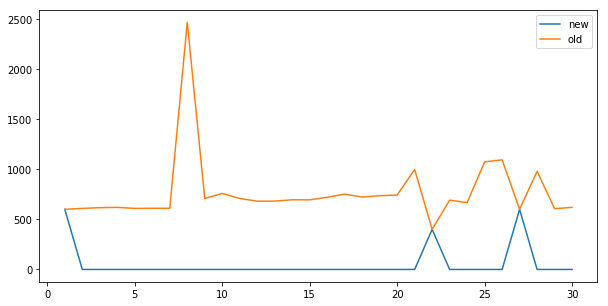

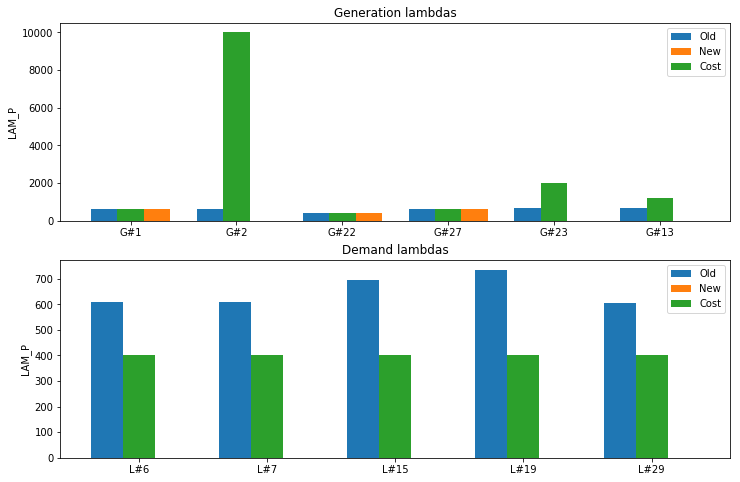

In [30]:
from drawings import draw_nice_hists, draw_nasty_profile
draw_nasty_profile(results)
draw_nice_hists(gens, results)

In [31]:
from utils import *
is_price_forming(results['gen'], results['gencost'], verbose=True)

Price forming bus #1	 C_g=600.000000
Price forming bus #22	 C_g=400.000000
Price forming bus #27	 C_g=600.000000


[0, 21, 26]

In [32]:
res_struct = Solver(ppc, ppopt, results,
                    threshold=threshold,
                    verbose=False)

Set mode
(0, 'direct')
(1, 'from pi and psi')


KeyboardInterrupt: 

In [ ]:
#all_sets = create_all_pos_settings()